# Demonstration Notebook for module fitramp

This notebook provides example code to fit ramps with and without fitting the reset value (the pedestal), to fit and mask jumps within or between groups of reads, and to compute the bias of ramp fitting from having to estimate the covariance matrix (and how to avoid this bias).

In [1]:
import numpy as np
import fitramp
import matplotlib.pyplot as plt
from matplotlib import rcParams
import time

In [2]:
Npix = 5000                          # pixels per row
nrows = 1000                         # number of rows of pixels
countrate = 2*np.ones((nrows, Npix)) # count rate for each pixel
sig = 20*np.ones((nrows, Npix))      # uncertainty for each pixel

Read times are calculated from the reset time.  The first read time should be positive.  You may use any combination of read times here.  Each element in the list should be a number (for a single read) or a list of numbers (for a resultant composed of more than one read).  The sample set of read times below has ten resultants.

Please note that all uncertainties are assumed to be in units of electrons and all count rates are in electrons/time (electrons/s assuming the readtimes are in seconds after reset).  If the gain is not unity then please multiply your data by the gain to convert units to electrons before using these routines, and ensure that your read noise is similarly given in units of electrons.

In [3]:
readtimes = [1, 2, 3, [4, 5], [6, 7, 8], [10, 11, 13], [15, 18],
             [21, 22], 23, [25, 26]]

# Use the code below to do the same checks on a ramp of 30 individual reads.
#readtimes = np.arange(1, 31)

Compute the covariance matrix and associated quantities, and then make a bunch of sample ramps.  Once we have these sample ramps compute the scaled differences between adjacent resultants.  As currently implemented, these differences must be computed before fitting anything.  The `getramps` step assumes a perfect detector with Gaussian read noise and Poisson photon noise.  

In [4]:
C = fitramp.Covar(readtimes)

im = np.empty((len(readtimes), nrows, Npix))
for i in range(nrows):
    im[:, i] = fitramp.getramps(countrate[i], sig[i], readtimes, nramps=Npix)
d = (im[1:] - im[:-1])/C.delta_t[:, np.newaxis, np.newaxis]

Check the time cost.

This section implements the suggested approach without jump detection: fit for the count rate, then refit to avoid bias.  Make sure not to estimate the covariance matrix with negative count rates when refitting.

Estimate the total time to process an H4RG or per $10^8$ pixel-resultants.  The time cost depends on whether you want to debias.

The calculation with jump detection is later.

An explicit for loop over one of the two dimensions of `d` is much more efficient in memory than vectorizing `fit_ramps` over a 2D array.  This is because of how arrays are accessed when building the intermediate quantities defined through recursion relations.  The subarray `d[:, i]` is immediately copied into an array contiguous in memory when `fit_ramps` is called.

In [5]:
t0 = time.time()
debias = True

for i in range(nrows):
    result = fitramp.fit_ramps(d[:, i], C, sig[i])
    
    if debias:
        countrateguess = result.countrate*(result.countrate > 0)
        result = fitramp.fit_ramps(d[:, i], C, sig[i],
                                   countrateguess=countrateguess)

    # The count rates, chi squared values, and uncertainties for this row are:
    # result.countrate
    # result.chisq
    # result.uncert
    #
    # You can save these to another structure if you want, or you can 
    # reorganize the structure for result used here.
        
    # Note: if we want the weights, they are available, as follows.

    # Weights on the scaled resultant differences:
    
    #weights_differences = result.weights

    # Or the equivalent weights on the resultants themselves:
    
    #weights_resultants = np.zeros(d[:, i].shape)
    #weights_resultants[1:] = result.weights/C.delta_t[:, np.newaxis]
    #weights_resultants[:-1] -= result.weights/C.delta_t[:, np.newaxis]
    
print("\nTime per H4RG: %.3g seconds" %
      ((time.time() - t0)*4096**2/(Npix*nrows)))

print("Time per 1e8 pixel-resultants: %.3g seconds" %
      ((time.time() - t0)*1e8/np.prod(d.shape)))


Time per H4RG: 9.85 seconds
Time per 1e8 pixel-resultants: 6.53 seconds


If we want the pedestal values (reset values), we can get those by prepending a couple of terms to the covariance matrix and changing our vector of resultant differences by prepending the first resultant.

If you have a prior on the reset value, you can include that, too with the keywords `resetval` and `resetsig`.  These should be either floats or arrays.  The default value of `resetsig=np.inf` is equivalent to a uniform prior on the pedestal.

The computational cost of the block below is nearly identical to that of the block above with `debias=False`.

In [6]:
C_wped = fitramp.Covar(readtimes, pedestal=True)
d_wped = np.zeros(im.shape)
d_wped[0] = im[0]/C.mean_t[0]
d_wped[1:] = (im[1:] - im[:-1])/C.delta_t[:, np.newaxis, np.newaxis]

for i in range(nrows):
    result = fitramp.fit_ramps(d_wped[:, i], C_wped, sig[i],
                               resetval=0, resetsig=np.inf)

    # The count rates, chi squared values, pedestals, and uncertainties are then:
    #
    # result.countrate
    # result.chisq
    # result.uncert
    # result.pedestal
    # result.uncert_pedestal
    # result.covar_countrate_pedestal

We can also calculate the bias from estimating the covariance matrix from the data themselves as described in the paper.  In the example below I am estimating the bias from averaging together all of the scaled resultant differences with equal weights (a `cvec` of all ones).

This can be used to remake the figure in the paper, or a similar figure for any set of read times (the set of read times in the paper is different from the set used here).

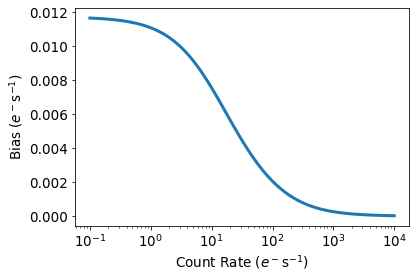

In [7]:
sig_bias = 10
countrates = 10**(np.linspace(-1, 4, 100))
cvec = np.ones(d.shape[0])
bias_constant_c = C.calc_bias(countrates, sig_bias, cvec)
plt.figure(figsize=(6, 4))
rcParams['font.size'] = 13.5
plt.semilogx(countrates, bias_constant_c, linewidth=3)
plt.xlabel("Count Rate ($e^-{\\rm s}^{-1}$)")
plt.ylabel("Bias ($e^-{\\rm s}^{-1}$)")
plt.show()

Now I show the implementation and time cost of jump detection. 

Resultant differences with `diffs2use=0` will be those where cosmic rays are identified.  The cost of this step is about 2-5 times the cost of fitting a ramp as above, weakly dependent on how common jumps are.  It returns the count rate and that binary mask showing which resultant differences should and should not be used given the thresholds adopted.  The thresholds given of `threshold_oneomit=20.25` and `threshold_twoomit=23.8` are the default values, which produce false positive rates equivalent to 4.5 Gaussian sigma.

After the initial step of jump detection there will be one more ramp fit.  The `mask_jumps` step returns the count rates but not the uncertainties or chi squared values.  We can do a little better and debias by running one more ramp fit after `mask_jumps`.  Make sure not to use negative count rates to estimate the covariance matrix!
   
If you want to fit the pedestals, you may do so by substituting `d_wped` and `C_wped` (as defined in a previous cell) for `d` and `C`, respectively, in the call to `fitramp.fit_ramps`, and by prepending ones to `diffs2use` in the following way:

`diffs2use_wped = np.ones(d.shape)`

`diff2use_wped[1:] = diffs2use`

In [8]:
t0 = time.time()

for i in range(nrows):

    diffs2use, countrates = fitramp.mask_jumps(d[:, i], C, sig[i], threshold_oneomit=20.25,
                                               threshold_twoomit=23.8)
    
    result = fitramp.fit_ramps(d[:, i], C, sig[i], diffs2use=diffs2use,
                               countrateguess=countrates*(countrates > 0))
    
print("\nTime per H4RG with jump detection & debiasing: %.3g seconds" %
      ((time.time() - t0)*4096**2/(nrows*Npix)))

print("Time per 1e8 pixel-resultants with jump detection & debiasing: %.3g seconds" %
      ((time.time() - t0)*1e8/np.prod(d.shape)))


Time per H4RG with jump detection & debiasing: 21 seconds
Time per 1e8 pixel-resultants with jump detection & debiasing: 13.9 seconds


Now show how we can use this information to get the jumps at all pixels for all resultant differences, and the uncertainties for all of those jumps.  

To run this in practice, you would include it within the loop above.  I have copied and pasted the code there for reference.

I am adding a noticeable (but not very large) jump in resultant difference index 2 to show how this works.  

In [9]:
ijump = 2
x, y = np.meshgrid(np.arange(d.shape[2]), np.arange(d.shape[1]))
d = (im[1:] - im[:-1])/C.delta_t[:, np.newaxis, np.newaxis]
d[ijump] += 5*np.exp(-((x - x.mean())**2 + (y - y.mean())**2)/(2*200**2))

In [10]:
alljumps = np.zeros(d.shape)
alljumpsigs = np.zeros(d.shape)

for i in range(nrows):
    diffs2use, countrates = fitramp.mask_jumps(d[:, i], C, sig[i], threshold_oneomit=20.25,
                                               threshold_twoomit=23.8)
    ct = countrates*(countrates > 0)
    result = fitramp.fit_ramps(d[:, i], C, sig[i], diffs2use=diffs2use, 
                               detect_jumps=True, countrateguess=ct)

    alljumps[:, i] = result.jumpval_oneomit
    alljumpsigs[:, i] = result.jumpsig_oneomit
    
    for j in range(len(d)): 
        indx = diffs2use[j] == 0 # only need to redo these differences

        if np.sum(indx) == 0:
            continue

        # each time we'll make sure that this difference isn't masked
        mask = diffs2use[:, indx]*1
        mask[j] = 1
    
        result = fitramp.fit_ramps(d[:, i, indx], C, sig[i, indx], diffs2use=mask,
                                   detect_jumps=True, countrateguess=ct[indx])
    
        # Overwrite the jump value if it was previously masked.
        alljumps[j, i, indx] = result.jumpval_oneomit[j]
        alljumpsigs[j, i, indx] = result.jumpsig_oneomit[j]

And we can see the jump that I put in by hand earlier.  I will compare this to just resultant difference index 2 minus the median along the first axis.  The images look the same, but the first case is a bit cleaner.  The difference between the images is more noticeable if you are towards the middle of a ramp consisting of many individual reads, and read noise dominates.

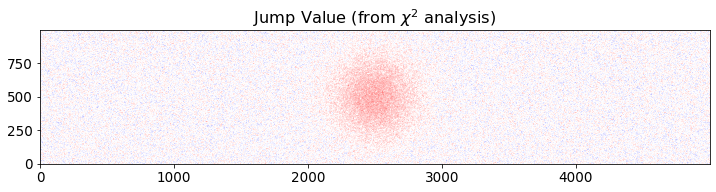

<Figure size 432x288 with 0 Axes>

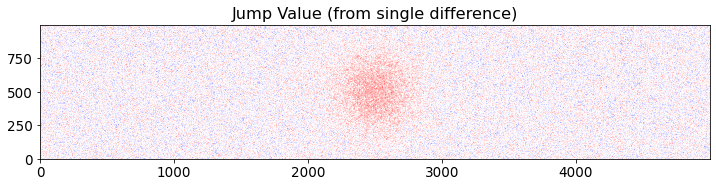

In [11]:
plt.figure(figsize=(12, 4))
maxval = np.amax(np.abs(alljumps[ijump]))*0.5
plt.imshow(alljumps[ijump], origin='lower', cmap='seismic',
           vmin=-maxval, vmax=maxval)
plt.title("Jump Value (from $\chi^2$ analysis)")
plt.show()
plt.clf()
plt.figure(figsize=(12, 4))
plt.imshow(d[ijump] - np.median(d, axis=0), origin='lower', cmap='seismic',
           vmin=-maxval, vmax=maxval)
plt.title("Jump Value (from single difference)")
plt.show()